# MAHTS stats

In [44]:
!df -H

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   12G   96G  11% /
tmpfs            68M     0   68M   0% /dev
tmpfs            67G     0   67G   0% /sys/fs/cgroup
/dev/nvme0n1p1  108G   12G   96G  11% /notebooks
/dev/nvme1n1     11G  9.5G  933M  92% /home/jovyan
shm              68M   50k   68M   1% /dev/shm
tmpfs            67G     0   67G   0% /proc/acpi
tmpfs            67G     0   67G   0% /sys/firmware


## Background


## Description



## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [370]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

# pip install --user ruptures

import sys
import glob
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import ruptures as rpt
from scipy import stats
from shapely.wkt import loads
from shapely.ops import nearest_points
from rasterio.features import rasterize
from skimage.morphology import disk
from skimage.morphology import square
from skimage.morphology import binary_opening
from skimage.morphology import binary_dilation

sys.path.append('../Scripts')
from dea_spatialtools import largest_region
from dea_spatialtools import subpixel_contours
from dea_spatialtools import largest_region
from dea_plotting import map_shapefile

def change_regress(row, 
                   x_vals, 
                   x_labels, 
                   std_dev=3, 
                   detrend_params=None,
                   slope_var='slope', 
                   interc_var='intercept',
                   pvalue_var='pvalue', 
                   outliers_var='outliers'):
    
    # Extract x (time) and y (distance) values
    x = x_vals
    y = row.values.astype(np.float)
    
    # Drop NAN rows
    xy_df = np.vstack([x, y]).T
    is_valid = ~np.isnan(xy_df).any(axis=1)
    xy_df = xy_df[is_valid]
    valid_labels = x_labels[is_valid]
    
    # If detrending parameters are provided, apply these to the data to
    # remove the trend prior to running the regression
    if detrend_params:
        xy_df[:,1] = xy_df[:,1]-(detrend_params[0]*xy_df[:,0]+detrend_params[1])    
    
    # Remove outliers
    outlier_bool = (np.abs(stats.zscore(xy_df)) < float(std_dev)).all(axis=1)
    xy_df = xy_df[outlier_bool]
        
    # Compute linear regression
    lin_reg = stats.linregress(x=xy_df[:,0], 
                               y=xy_df[:,1])  
       
    # Return slope, p-values and list of outlier years excluded from regression   
    return pd.Series({slope_var: np.round(lin_reg.slope, 3), 
                      interc_var: np.round(lin_reg.intercept, 3),
                      pvalue_var: np.round(lin_reg.pvalue, 3),
                      outliers_var: ' '.join(map(str, valid_labels[~outlier_bool]))})


def breakpoints(x, model='rbf', pen=10, min_size=2, jump=1):
    signal = x.values
    algo = rpt.Pelt(model=model, min_size=min_size, jump=jump).fit(signal)
    result = algo.predict(pen=pen)
    if len(result) > 1:
        return [x_years[i] for i in result[0:-1]][0]
    else:
        return None

    
def mask_ocean(bool_array, connectivity=1):
    '''
    Identifies ocean by selecting the largest connected area of water
    pixels, then dilating this region by 1 pixel to include mixed pixels
    '''
    
    ocean_mask = largest_region(bool_array, connectivity=connectivity)
    ocean_mask = binary_dilation(ocean_mask, selem=square(3))

    return ocean_mask


# # This will speed up loading data
# import datacube.utils.rio
# datacube.utils.rio.configure_s3_access(aws_unsigned=True)


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [425]:
# df = pd.read_csv('input_data/soi_all.csv')
# df_long = pd.melt(df, id_vars=['year'], var_name='month')
# df_long['month'] = df_long.month.astype(int)
# df_long = df_long.sort_values(['year', 'month'])
# df_long.head()

# df_long['yearly_ave'] = df_long.value.rolling(window=12).mean()

# names_dict = {-12: 'feb', -11: 'mar', -10: 'apr', -9: 'may', 
#               -8: 'jun', -7: 'jul', -6: 'aug', -5: 'sep', 
#               -4: 'oct', -3: 'nov', -2: 'dec', -1: 'jan'}

# out = {}
# for i in [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]:
#     out[names_dict[i]] = df_long.groupby('year').nth(i).yearly_ave
# prev_year = pd.concat(out, axis=1).loc[:,list(names_dict.values())].add_prefix('-1_')
# prev_year = prev_year.rename({'-1_jan': '0_jan'}, axis=1)
# prev_year.tail()

# df_shifted = df_long.shift(-12)
# df_shifted['year'] = df_shifted.year.fillna(2020)
# df_shifted['yearly_ave'] = df_shifted.value.rolling(window=12).mean()

# out = {}
# for i in [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]:
#     out[names_dict[i]] = df_shifted.groupby('year').nth(i).yearly_ave
# current_year = pd.concat(out, axis=1).loc[:,list(names_dict.values())].add_prefix('0_')
# current_year = current_year.rename({'0_jan': '1_jan'}, axis=1)
# current_year.index = current_year.index - 1
# current_year.tail()

# df_shifted = df_long.shift(12)
# df_shifted['year'] = df_shifted.year.fillna(1984)
# df_shifted['yearly_ave'] = df_shifted.value.rolling(window=12).mean()

# out = {}
# for i in [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]:
#     out[names_dict[i]] = df_shifted.groupby('year').nth(i).yearly_ave
# prevprev_year = pd.concat(out, axis=1).loc[:,list(names_dict.values())].add_prefix('-2_')
# prevprev_year = prevprev_year.rename({'-2_jan': '-1_jan'}, axis=1)
# prevprev_year.index = prevprev_year.index + 1
# prevprev_year.tail()

# climate_df = pd.concat([prevprev_year, prev_year, current_year], axis=1).loc[range(1987, 2019)]
# climate_df.head()

,-2_feb,-2_mar,-2_apr,-2_may,-2_jun,-2_jul,-2_aug,-2_sep,-2_oct,-2_nov,...,0_apr,0_may,0_jun,0_jul,0_aug,0_sep,0_oct,0_nov,0_dec,1_jan
year,,,,,,,,,,,,,,,,,,,,,
1987,1.816667,0.366667,0.600000,-0.500000,-1.283333,0.408333,0.783333,-0.558333,-1.008333,-0.033333,...,-10.425000,-8.500000,-5.866667,-4.516667,-2.025000,0.383333,2.991667,4.675000,6.541667,7.816667
1988,-3.575000,-3.733333,-5.183333,-7.316667,-8.566667,-11.133333,-12.866667,-13.400000,-13.900000,-14.875000,...,10.541667,12.400000,12.791667,13.733333,13.575000,11.808333,10.608333,10.000000,8.083333,6.766667
1989,-12.641667,-12.008333,-10.425000,-8.500000,-5.866667,-4.516667,-2.025000,0.383333,2.991667,4.675000,...,2.108333,0.316667,0.183333,-0.350000,-0.675000,-0.566667,-1.675000,-2.133333,-2.408333,-2.191667
1990,9.008333,10.183333,10.541667,12.400000,12.791667,13.733333,13.575000,11.808333,10.608333,10.000000,...,-0.358333,-1.391667,-4.091667,-4.633333,-5.233333,-5.450000,-6.200000,-7.425000,-7.591667,-8.783333
1991,5.575000,3.375000,2.108333,0.316667,0.183333,-0.350000,-0.675000,-0.566667,-1.675000,-2.133333,...,-13.283333,-13.766667,-12.116667,-12.725000,-13.158333,-12.408333,-10.958333,-11.316667,-11.316667,-10.383333


## Load in data

In [378]:
# Read in contours
study_area = 'goldcoast_test'
water_index = 'mndwi'
index_threshold = 0.00

# Get file paths
index_files = sorted(glob.glob(f'output_data/{study_area}/{water_index}_*.tif'))
stdev_files = sorted(glob.glob(f'output_data/{study_area}/stdev_*.tif'))
count_files = sorted(glob.glob(f'output_data/{study_area}/count_*.tif'))

# Create variable used for time axis
time_var = xr.Variable('year', [int(i[-8:-4]) for i in index_files])

# Import data
index_da = xr.concat([xr.open_rasterio(i) for i in index_files], dim=time_var)
stdev_da = xr.concat([xr.open_rasterio(i) for i in stdev_files], dim=time_var)
count_da = xr.concat([xr.open_rasterio(i) for i in count_files], dim=time_var)

# Assign names to allow merge
index_da.name = water_index
stdev_da.name = 'stdev'
count_da.name = 'count'

# Combine into a single dataset and set CRS
yearly_ds = xr.merge([index_da, stdev_da, count_da]).squeeze('band', drop=True)
yearly_ds.attrs['crs'] = index_da.crs
from affine import Affine
yearly_ds.attrs['transform'] = Affine(*index_da.transform)

# Print
yearly_ds

<xarray.Dataset>
Dimensions:  (x: 314, y: 2581, year: 33)
Coordinates:
  * y        (y) float64 6.881e+06 6.880e+06 6.88e+06 ... 6.803e+06 6.803e+06
  * x        (x) float64 5.536e+05 5.536e+05 5.537e+05 ... 5.63e+05 5.63e+05
  * year     (year) int64 1987 1988 1989 1990 1991 ... 2015 2016 2017 2018 2019
Data variables:
    mndwi    (year, y, x) float32 -0.13962284 -0.16169216 ... 0.18139905
    stdev    (year, y, x) float32 0.043762274 0.031229421 ... 0.034875028
    count    (year, y, x) int16 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 2 2 2
Attributes:
    crs:        +init=epsg:32756
    transform:  | 30.00, 0.00, 553605.00|\n| 0.00,-30.00, 6880545.00|\n| 0.00...

## Extract shoreline contours

### Extract ocean-masked contours

Operating in single z-value, multiple arrays mode
Writing contours to output_data/goldcoast_test_3m/goldcoast_test_3m_contours_mndwi_0.00.geojson


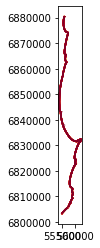

In [379]:
# Apply index and threshold
thresholded_ds = (yearly_ds[water_index] > index_threshold)

# Load estuary mask
# bbox = gpd.GeoSeries(loads(yearly_ds.geobox.extent.wkt), crs=yearly_ds.crs)
from shapely.geometry import box
bbox = gpd.GeoSeries(box(yearly_ds.x.min().item(), 
                         yearly_ds.y.min().item(), 
                         yearly_ds.x.max().item(), 
                         yearly_ds.y.max().item()), crs=yearly_ds.crs)
estuary_gdf = (gpd.read_file('./input_data/estuary_mask.shp', bbox=bbox)
               .to_crs(yearly_ds.crs))

# Rasterize estuary polygons into a numpy mask
estuary_mask = rasterize(shapes=estuary_gdf['geometry'],
                         out_shape=yearly_ds[water_index].shape[1:],
                         transform=yearly_ds.transform,
                         all_touched=True).astype(bool)

# Drop empty timesteps and apply estuary mask
thresholded_ds = (thresholded_ds
                  .sel(year=thresholded_ds.sum(dim=['x', 'y']) > 0)
                  .where(~estuary_mask, 0))

# Identify ocean by identifying the largest connected area of water pixels
# in a median composite of the entire stack of thresholded water index results
# all_time_median = thresholded_ds.median(dim='year')
all_time_median = (thresholded_ds.sum(dim='year') > (32 * 0.9))
full_sea_mask = mask_ocean(binary_opening(all_time_median, disk(3)))

# Generate all time 600 m buffer from ocean-land boundary
buffer_ocean = binary_dilation(full_sea_mask, disk(25))
buffer_land = binary_dilation(~full_sea_mask, disk(25))
coastal_buffer = buffer_ocean & buffer_land

# Generate sea mask for each timestep
yearly_sea_mask = thresholded_ds.groupby('year').apply(mask_ocean)

# Keep only pixels that are within 600 m of the ocean in the
# full stack, and directly connected to ocean in each yearly timestep
masked_ds = yearly_ds[water_index].where(yearly_sea_mask & coastal_buffer)

# Set CRS and trasnform from input data
masked_ds.attrs['crs'] = yearly_ds.crs[6:]
masked_ds.attrs['transform'] = yearly_ds.transform

# Extract contours
output_path = f'output_data/{study_area}/{study_area}_contours_{water_index}_{index_threshold:.2f}'
contours_gdf = subpixel_contours(da=masked_ds,
                                 z_values=index_threshold,
                                 output_path=f'{output_path}.geojson',
                                 dim='year')

# Plot
contours_gdf.plot(column='year', cmap='YlOrRd')

### Extract cleaned contours

Operating in single z-value, multiple arrays mode
Writing contours to output_data/goldcoast_test_3m/goldcoast_test_3m_contours_mndwi_0.00_cleaned.geojson


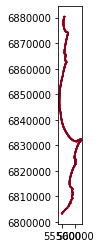

In [380]:
# Keep only pixels that are within 600 m of the ocean in the
# full stack, and directly connected to ocean in each yearly timestep
cleaned_ds = masked_ds.where((yearly_ds['count'] >= 5) & (yearly_ds['stdev'] < 0.5))

# Extract contours
contours_clean_gdf = subpixel_contours(da=cleaned_ds.isel(year=range(1, 32)),
                                 z_values=index_threshold,
                                 output_path=f'{output_path}_cleaned.geojson',
                                 dim='year')

# Plot
contours_clean_gdf.plot(column='year', cmap='YlOrRd')

In [365]:
# Plot
# map_shapefile(gdf=contours_gdf, hover_col='year')

## Compute statistics
### Measure distances from baseline

In [381]:
# Get array of water index values for baseline time period 
baseline_year = '1990'
baseline_array = yearly_ds[water_index].sel(year=int(baseline_year))

# Import contours and project to local CRS
contours_index_gdf = contours_gdf.set_index('year')

# Set annual shoreline to use as a baseline
baseline_contour = contours_index_gdf.loc[[baseline_year]].geometry

# Generate points along line and convert to geopandas.GeoDataFrame
points_line = [baseline_contour.iloc[0].interpolate(i) 
               for i in range(0, int(baseline_contour.length), 30)]
points_gdf = gpd.GeoDataFrame(geometry=points_line, crs=baseline_array.crs)

# Copy geometry to baseline point
points_gdf['p_baseline'] = points_gdf.geometry
baseline_x_vals = points_gdf.geometry.x
baseline_y_vals = points_gdf.geometry.y

# Iterate through all comparison years in contour gdf
for comp_year in contours_index_gdf.index.unique().values[0:32]:

    print(comp_year)

    # Set comparison contour
    comp_contour = contours_index_gdf.loc[[comp_year]].geometry.iloc[0]

    # Find nearest point on comparison contour
    points_gdf[f'p_{comp_year}'] = points_gdf.apply(lambda x: 
                                                    nearest_points(x.p_baseline, comp_contour)[1], axis=1)

    # Compute distance between baseline and comparison year points
    points_gdf[f'{comp_year}'] = points_gdf.apply(lambda x: 
                                                  x.geometry.distance(x[f'p_{comp_year}']), axis=1)

    # Extract comparison array
    comp_array = yearly_ds[water_index].sel(year=int(comp_year))

    # Convert baseline and comparison year points to geoseries to allow easy access to x and y coords
    comp_x_vals = gpd.GeoSeries(points_gdf[f'p_{comp_year}']).x
    comp_y_vals = gpd.GeoSeries(points_gdf[f'p_{comp_year}']).y

    # Sample NDWI values from arrays based on baseline and comparison points
    baseline_x_vals = xr.DataArray(baseline_x_vals, dims='z')
    baseline_y_vals = xr.DataArray(baseline_y_vals, dims='z')
    comp_x_vals = xr.DataArray(comp_x_vals, dims='z')
    comp_y_vals = xr.DataArray(comp_y_vals, dims='z')   
    points_gdf['index_comp_p1'] = comp_array.interp(x=baseline_x_vals, y=baseline_y_vals)
    points_gdf['index_baseline_p2'] = baseline_array.interp(x=comp_x_vals, y=comp_y_vals)

    # Compute directionality of change (negative = erosion, positive = accretion)    
    points_gdf['loss_gain'] = np.where(points_gdf.index_baseline_p2 > 
                                       points_gdf.index_comp_p1, 1, -1)
    points_gdf[f'{comp_year}'] = points_gdf[f'{comp_year}'] * points_gdf.loss_gain
    
# Keep required columns
points_gdf = points_gdf[['geometry'] + 
                        contours_index_gdf.index.unique().values.tolist()[0:32]]
points_gdf = points_gdf.round(2)

# Identify dates for regression
x_years = np.array([int(i[:4]) for i in points_gdf.columns[1:]])

1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


### Calculate regressions

In [382]:
# Identify SOI values for regression
climate_df = pd.read_csv('input_data/climate_indices.csv', index_col='year')
climate_df = climate_df.loc[:,['SOI']]

# Compute change rates
rate_out = points_gdf.apply(lambda x: change_regress(row=x[1:33], 
                                                     x_vals = x_years, 
                                                     x_labels = x_years, 
                                                     std_dev=3), axis=1)
points_gdf[['rate_time', 'incpt_time', 'sig_time', 'outl_time']] = rate_out

# Compute stats for each index
for ci in climate_df:
    
    print(ci)
    
    # Compute stats for each row
    ci_out = points_gdf.apply(lambda x: change_regress(row=x[1:33],
                                                       x_vals = climate_df[ci].values, 
                                                       x_labels = x_years, 
                                                       detrend_params=[x.rate_time, x.incpt_time],
                                                       std_dev=3), axis=1)
    
    # Add data as columns  
    points_gdf[[f'rate_{ci}', f'incpt_{ci}', f'sig_{ci}', f'outl_{ci}']] = ci_out


# Add breakpoints
points_gdf['breakpoints'] = points_gdf.apply(lambda x: breakpoints(x=x[1:33], pen=10), axis=1)

# Set CRS
points_gdf.crs = baseline_array.crs


-2_feb
-2_mar
-2_apr
-2_may
-2_jun
-2_jul
-2_aug
-2_sep
-2_oct
-2_nov
-2_dec
-1_jan
-1_feb
-1_mar
-1_apr
-1_may
-1_jun
-1_jul
-1_aug
-1_sep
-1_oct
-1_nov
-1_dec
0_jan
0_feb
0_mar
0_apr
0_may
0_jun
0_jul
0_aug
0_sep
0_oct
0_nov
0_dec
1_jan


## Output file

In [368]:
# output_filename = f'output_data/{study_area}/{study_area}_stats_{water_index}_{index_threshold}.geojson'
# points_gdf.to_file(output_filename, driver='GeoJSON')


## Test lags

In [383]:
# points_gdf_filtered = points_gdf.drop('sig_time', axis=1).filter(regex='sig')
# output_filename = f'output_data/{study_area}/{study_area}_stats_{water_index}_{index_threshold}_offsets.csv'
# points_gdf_filtered.to_csv(output_filename, index=False)

In [423]:
# output_filename

In [384]:
# import pandas as pd
# points_gdf_filtered_minus6m = pd.read_csv('output_data/goldcoast_test_-6m/goldcoast_test_-6m_stats_mndwi_0.0_offsets.csv')
# points_gdf_filtered_minus3m = pd.read_csv('output_data/goldcoast_test_-3m/goldcoast_test_-3m_stats_mndwi_0.0_offsets.csv')
# points_gdf_filtered = pd.read_csv('output_data/goldcoast_test/goldcoast_test_stats_mndwi_0.0_offsets.csv')
# points_gdf_filtered_3m = pd.read_csv('output_data/goldcoast_test_3m/goldcoast_test_3m_stats_mndwi_0.0_offsets.csv')
# points_gdf_filtered_6m = pd.read_csv('output_data/goldcoast_test_6m/goldcoast_test_6m_stats_mndwi_0.0_offsets.csv')

In [422]:
# import matplotlib as mpl
# mpl.rc('image', cmap='YlOrRd')

# (points_gdf_filtered_minus6m < 0.05).sum(axis=0).plot(figsize=(10, 8), title='Number of significant results', label='July same year (+6 m)', c=mpl.cm.YlOrRd(70), linewidth=2.2)
# (points_gdf_filtered_minus3m < 0.05).sum(axis=0).plot(label='April same year (+3 m)', c=mpl.cm.YlOrRd(130), linewidth=2.2)
# (points_gdf_filtered < 0.05).sum(axis=0).plot(label='Calendar year (0 m)', c=mpl.cm.YlOrRd(180), linewidth=2.2)
# (points_gdf_filtered_3m < 0.05).sum(axis=0).plot(label='Oct prev year (-3 m)', c=mpl.cm.YlOrRd(250), linewidth=2.2)
# (points_gdf_filtered_6m < 0.05).sum(axis=0).plot(label='July prev year (-6 m)', c='black', linewidth=2.2)
# import matplotlib.pyplot as plt
# plt.legend(loc='upper left')
# plt.axvline(x=23, color='grey')

In [424]:
# (points_gdf_filtered < 0.05).sum(axis=0).plot(figsize=(10, 8), title='Number of significant results')
# (points_gdf_filtered_3m < 0.05).sum(axis=0).plot()
# # (points_gdf_filtered_6m < 0.05).sum(axis=0).plot()


In [55]:
# has_sig = points_gdf_sorted.drop('geometry', axis=1).min(axis=1) < 0.05

In [56]:
# # Custom sorting
# points_gdf_sorted = points_gdf.loc[:, [
#     'rate_SOI', 'rate_SOIapril',
#     'sig_SOI', 'sig_SOIapril', 
#     'outl_SOI', 'outl_SOIapril', 'geometry'
# ]]

# # Insert ID for bug finding
# points_gdf_sorted.insert(0, 'id', range(0, len(points_gdf_sorted)))

# points_gdf_sorted[has_sig].shape

In [57]:
# points_gdf_sorted.mean(axis=0).plot(figsize=(10, 8), title='Average p-value')

In [58]:
# ((points_gdf_sorted[has_sig].drop(['geometry', 'best_sig'], axis=1) < 0.05).sum(axis=0) / points_gdf_sorted[has_sig].shape[0]).plot(figsize=(10, 8), title='Number of significant results')

In [59]:
# points_gdf_sorted[has_sig].shape[0]

In [60]:
# points_gdf_sorted['diff'] = points_gdf_sorted['sig_SOI'] - points_gdf_sorted['sig_SOIapril']

## Evaluation

### Time history

In [61]:
# id_val = 6118
# plot_df = pd.DataFrame({
#     'mov': points_gdf.loc[id_val, contours_gdf.index.to_list()].values.astype(float),
#     'time': x_years,
#     'soi': climate_df['SOI'].values
# })

# plot_df.plot.scatter(x='time',
#                      y='mov',
#                      c='soi',
#                      cmap='RdYlBu',
#                      s=50,
#                      edgecolors="black")

# plot_df.plot.scatter(x='soi',
#                      y='mov',
#                      c='soi',
#                      cmap='RdYlBu',
#                      s=50,
#                      edgecolors="black")


### Test breakpoints

In [62]:
# id_val = 6015
# signal = points_gdf.loc[id_val,contours_gdf.index.to_list()].values

# # detection
# algo = rpt.Pelt(model="rbf", min_size=2, jump=1).fit(signal)
# result = algo.predict(pen=8)
# print(contours_gdf.index.to_list()[result[0]])
# rpt.display(signal, [32], result)


### Index correlation

In [63]:
# corr = climate_df.corr()
# corr.style.background_gradient(cmap='RdBu')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [64]:
print(datacube.__version__)

1.7+130.g81bed714.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)